In [54]:
import torch
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as T

def plot_image_and_histogram(img, title="Imagen y Histograma"):
    """
    Muestra una imagen RGB o en escala de grises junto a su histograma.
    Acepta una imagen PIL o un tensor (1 o 3 canales).
    """
    if isinstance(img, Image.Image):
        img = T.ToTensor()(img)

    if img.ndim != 3 or img.shape[0] not in [1, 3]:
        raise ValueError(f"Se esperaba un tensor con shape (1,H,W) o (3,H,W), pero se recibió {img.shape}")

    img_show = img.clone()

    if img.max() <= 1.0:
        img_uint8 = (img * 255).to(torch.uint8)
    else:
        img_uint8 = img.to(torch.uint8)
        img_show = (img_uint8.float() / 255.0).clamp(0, 1)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(title)

    if img.shape[0] == 3:
        axes[0].imshow(img_show.permute(1, 2, 0))
        axes[0].set_title("Imagen RGB")

        r, g, b = img_uint8[0].flatten(), img_uint8[1].flatten(), img_uint8[2].flatten()
        hist_r = torch.histc(r.float(), bins=256, min=0, max=255)
        hist_g = torch.histc(g.float(), bins=256, min=0, max=255)
        hist_b = torch.histc(b.float(), bins=256, min=0, max=255)

        axes[1].plot(hist_r.numpy(), color='red', label='Red')
        axes[1].plot(hist_g.numpy(), color='green', label='Green')
        axes[1].plot(hist_b.numpy(), color='blue', label='Blue')
        axes[1].set_title("Histograma RGB")
        axes[1].legend()

    elif img.shape[0] == 1:
        axes[0].imshow(img_show.squeeze(0), cmap="gray")
        axes[0].set_title("Imagen en escala de grises")

        gray = img_uint8[0].flatten()
        hist_gray = torch.histc(gray.float(), bins=256, min=0, max=255)

        axes[1].plot(hist_gray.numpy(), color='black', label='Gris')
        axes[1].set_title("Histograma de escala de grises")
        axes[1].legend()

    axes[0].axis("off")
    axes[1].set_xlabel("Intensidad (0–255)")
    axes[1].set_ylabel("Frecuencia")
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

In [55]:
from PIL import Image
import torchvision.transforms as T
import torch
import matplotlib.pyplot as plt

def histogram_equalization(img_tensor):
    if img_tensor.ndim == 3:
        img_tensor = img_tensor.squeeze(0)
    if img_tensor.max() <= 1.0:
        img_tensor = (img_tensor * 255).to(torch.uint8)

    flat = img_tensor.flatten()
    hist = torch.histc(flat.float(), bins=256, min=0, max=255)
    cdf = hist.cumsum(0)
    cdf_min = cdf[cdf > 0][0]
    cdf_normalized = ((cdf - cdf_min) * 255) / (cdf[-1] - cdf_min)
    cdf_normalized = cdf_normalized.clamp(0, 255).byte()
    equalized = cdf_normalized[flat.long()].reshape(img_tensor.shape)
    return equalized, hist, torch.histc(equalized.float(), bins=256, min=0, max=255)


In [56]:
from PIL import Image
import torchvision.transforms as T
import torch
import matplotlib.pyplot as plt

def equalize_channel(channel: torch.Tensor) -> torch.Tensor:
    if channel.max() <= 1.0:
        channel = (channel * 255).to(torch.uint8)
    
    flat = channel.flatten()
    hist = torch.histc(flat.float(), bins=256, min=0, max=255)
    cdf = hist.cumsum(0)
    cdf_min = cdf[cdf > 0][0]
    cdf_normalized = ((cdf - cdf_min) * 255 / (cdf[-1] - cdf_min)).clamp(0, 255).byte()
    equalized = cdf_normalized[flat.long()].reshape(channel.shape)
    return equalized.float() / 255.0  # devolver normalizado (0-1)

def equalize_image(img_tensor: torch.Tensor) -> torch.Tensor:
    """
    Aplica ecualización de histograma a una imagen RGB (3, H, W) o escala de grises (1, H, W).
    Devuelve un tensor normalizado (0 a 1) con la misma forma de entrada.
    """
    if img_tensor.ndim != 3 or img_tensor.shape[1] < 10 or img_tensor.shape[2] < 10:
        raise ValueError(f"Se esperaba un tensor con shape (C,H,W), pero se recibió {img_tensor.shape}")

    channels = img_tensor.shape[0]

    if channels == 1:
        eq = equalize_channel(img_tensor[0])
        return eq.unsqueeze(0) 
    elif channels == 3:
        r_eq = equalize_channel(img_tensor[0])
        g_eq = equalize_channel(img_tensor[1])
        b_eq = equalize_channel(img_tensor[2])
        return torch.stack([r_eq, g_eq, b_eq])
    else:
        raise ValueError(f"Número de canales no soportado: {channels}")



In [72]:
import torch
from torchvision.transforms.functional import rgb_to_grayscale, to_tensor, to_pil_image

def adaptive_hist_equalization(img_tensor: torch.Tensor, tile_size=32) -> torch.Tensor:
    """
    Aplica Adaptive Histogram Equalization (AHE) por bloques a una imagen RGB o en escala de grises.
    Si es RGB, ecualiza solo la luminancia y devuelve imagen RGB.
    Si es gris, devuelve imagen gris.
    """
    if img_tensor.ndim != 3 or img_tensor.shape[0] not in [1, 3]:
        raise ValueError(f"Se esperaba un tensor con shape (1,H,W) o (3,H,W), pero se recibió {img_tensor.shape}")

    is_rgb = img_tensor.shape[0] == 3

    # Convertir a escala de grises para ecualización
    gray_tensor = rgb_to_grayscale(img_tensor) if is_rgb else img_tensor
    c, h, w = gray_tensor.shape

    img_uint8 = (gray_tensor * 255).to(torch.uint8)
    out = torch.zeros_like(img_uint8)

    for y in range(0, h, tile_size):
        for x in range(0, w, tile_size):
            y_end = min(y + tile_size, h)
            x_end = min(x + tile_size, w)

            tile = img_uint8[0, y:y_end, x:x_end]
            flat = tile.flatten()
            hist = torch.histc(flat.float(), bins=256, min=0, max=255)
            cdf = hist.cumsum(0)
            cdf_min = cdf[cdf > 0][0]
            cdf_normalized = ((cdf - cdf_min) * 255 / (cdf[-1] - cdf_min)).clamp(0, 255).byte()
            eq_tile = cdf_normalized[flat.long()].reshape(tile.shape)
            out[0, y:y_end, x:x_end] = eq_tile

    # Normalizar de vuelta
    eq_gray = (out.float() / 255.0).clamp(0, 1)

    if is_rgb:
        # Reinyectar luminancia al RGB original
        rgb = img_tensor.clone()
        for c in range(3):
            rgb[c] = rgb[c] * (eq_gray[0] / (gray_tensor[0] + 1e-5))  # escalar cada canal proporcional
        return rgb.clamp(0, 1)
    else:
        return eq_gray

In [74]:
import torch

def tone_adjustment(img_tensor: torch.Tensor, alpha: float = 1.2, beta: float = 0.05) -> torch.Tensor:
    """
    Ajusta tono (contraste y brillo) a una imagen en formato tensor Torch.
    
    - alpha: factor de contraste (>1 aumenta, <1 reduce)
    - beta: desplazamiento de brillo (positivo ilumina)

    Si recibe imagen RGB (3, H, W), devuelve RGB.
    Si recibe imagen en escala de grises (1, H, W), devuelve gris.
    """
    if img_tensor.ndim != 3 or img_tensor.shape[0] not in [1, 3]:
        raise ValueError(f"Se esperaba imagen con shape (1,H,W) o (3,H,W), se recibió {img_tensor.shape}")

    adjusted = img_tensor * alpha + beta

    adjusted = adjusted.clamp(0, 1)

    return adjusted

In [78]:
import torch
import torch.nn.functional as F

def linear_blur(img_tensor, kernel_size=5):
    kernel = torch.ones((1, 1, kernel_size, kernel_size), dtype=torch.float32)
    kernel /= kernel.numel()
    channels = img_tensor.shape[0]
    return F.conv2d(img_tensor.unsqueeze(0), kernel.repeat(channels, 1, 1, 1), padding=kernel_size//2, groups=channels).squeeze(0)

In [80]:
def sharpen_image(img_tensor):
    kernel = torch.tensor([[[[0, -1, 0],
                             [-1, 5, -1],
                             [0, -1, 0]]]], dtype=torch.float32)
    channels = img_tensor.shape[0]
    return F.conv2d(img_tensor.unsqueeze(0), kernel.repeat(channels, 1, 1, 1), padding=1, groups=channels).clamp(0, 1).squeeze(0)

In [85]:
import cv2
import numpy as np
from torchvision.transforms import ToPILImage, ToTensor

def edge_preserving_smooth(img_tensor):
    pil_img = ToPILImage()(img_tensor)
    img_np = np.array(pil_img)
    filtered = cv2.bilateralFilter(img_np, d=9, sigmaColor=75, sigmaSpace=75)
    return ToTensor()(Image.fromarray(filtered))

In [87]:
def binarize_image(img_tensor, threshold=0.5):
    return (img_tensor > threshold).float()

In [89]:
def dilate_image(img_tensor, kernel_size=3):
    import cv2
    img = (img_tensor.squeeze().numpy() * 255).astype(np.uint8)
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    dilated = cv2.dilate(img, kernel, iterations=1)
    return torch.tensor(dilated, dtype=torch.float32).unsqueeze(0) / 255.0

In [96]:
def distance_transform(img_tensor, threshold=0.5):
    import cv2
    from torchvision.transforms.functional import rgb_to_grayscale

    if img_tensor.shape[0] == 3:
        img_tensor = rgb_to_grayscale(img_tensor)

    # Asegurar valores entre 0–255 y tipo uint8
    img_uint8 = (img_tensor.squeeze().numpy() * 255).astype(np.uint8)

    # Binarizar (con umbral) antes de aplicar distanceTransform
    _, binary = cv2.threshold(img_uint8, int(threshold * 255), 255, cv2.THRESH_BINARY)

    # Asegurar tipo correcto
    binary = binary.astype(np.uint8)

    # Aplicar transformada de distancia
    dist = cv2.distanceTransform(binary, distanceType=cv2.DIST_L2, maskSize=5)

    # Normalizar para visualizar (entre 0 y 1)
    dist_norm = (dist / (dist.max() + 1e-5)).astype(np.float32)

    return torch.tensor(dist_norm).unsqueeze(0)

In [100]:
def connected_components(img_tensor):
    import cv2
    from torchvision.transforms.functional import rgb_to_grayscale

    # Si es RGB, convertir a escala de grises
    if img_tensor.shape[0] == 3:
        img_tensor = rgb_to_grayscale(img_tensor)

    # Asegurar valores binarios 0 o 255 en uint8
    img_bin = (img_tensor.squeeze().numpy() > 0.5).astype(np.uint8) * 255

    # Ahora sí, aplicar connectedComponents
    num_labels, labels = cv2.connectedComponents(img_bin)

    # Normalizar para visualización
    labels_norm = (labels / labels.max()).astype(np.float32)

    return torch.tensor(labels_norm).unsqueeze(0), num_labels

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import torch

def plot_connected_components(labels_tensor: torch.Tensor, num_labels: int, title="Componentes Conectados"):
    """
    Muestra una imagen de etiquetas con colores diferentes por componente.
    """
    if labels_tensor.ndim == 3:
        labels_tensor = labels_tensor.squeeze(0)  # (H, W)

    labels_np = labels_tensor.numpy()

    # Mapeo de colores usando un colormap (p.ej. tab20 o viridis)
    colormap = cm.get_cmap("tab20", num_labels)  # o "nipy_spectral"
    color_image = colormap(labels_np / max(1, num_labels - 1))  # RGBA

    plt.figure(figsize=(6, 6))
    plt.imshow(color_image)
    plt.title(f"{title} (n = {num_labels})")
    plt.axis("off")
    plt.show()

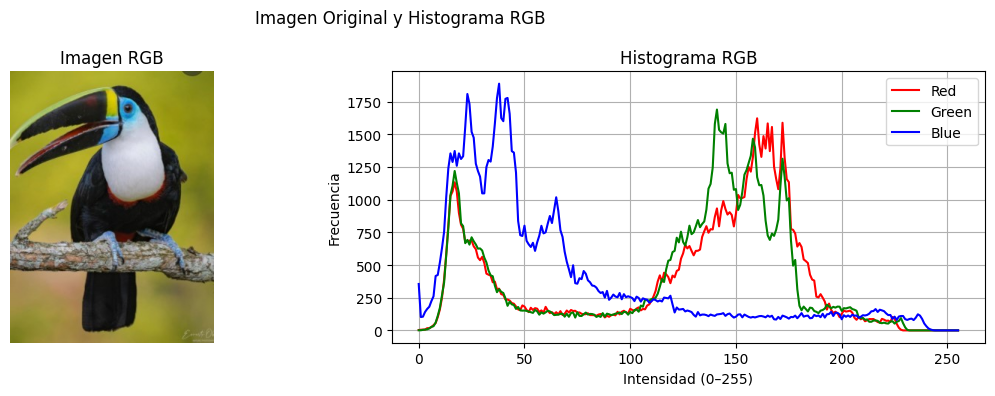

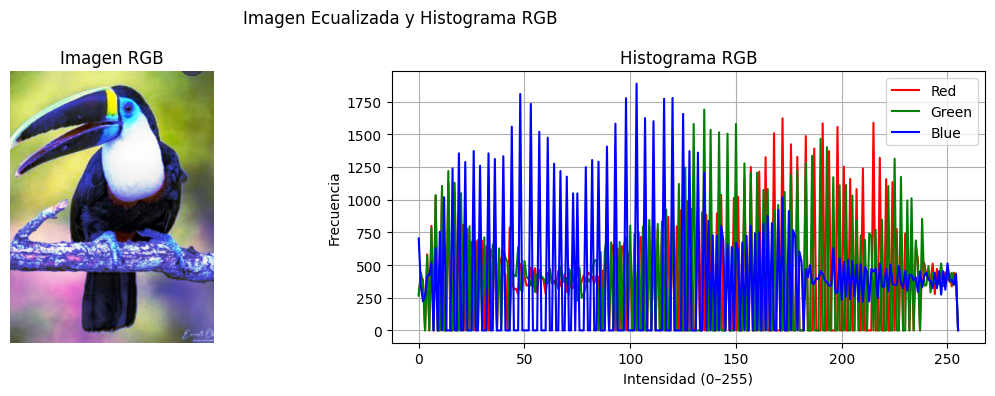

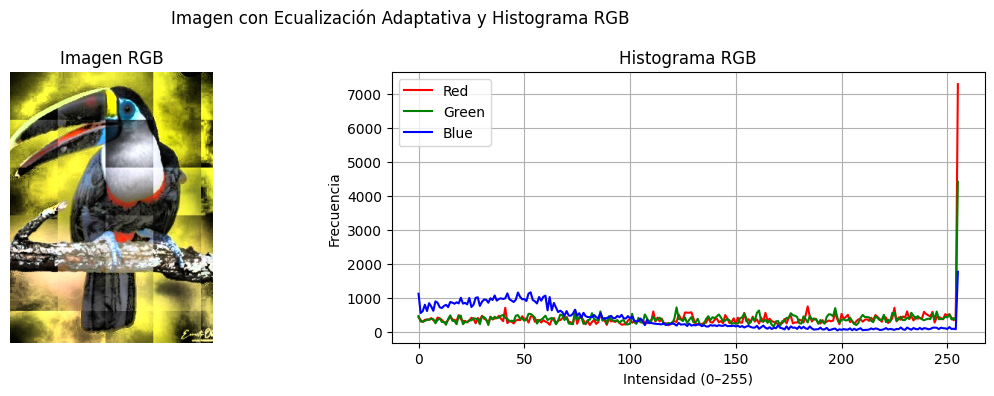

************************************************************
Ajuste de Tono:
************************************************************


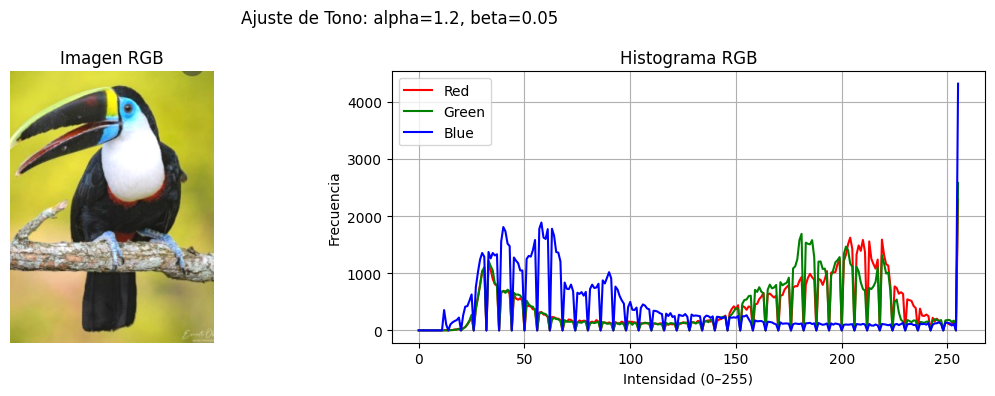

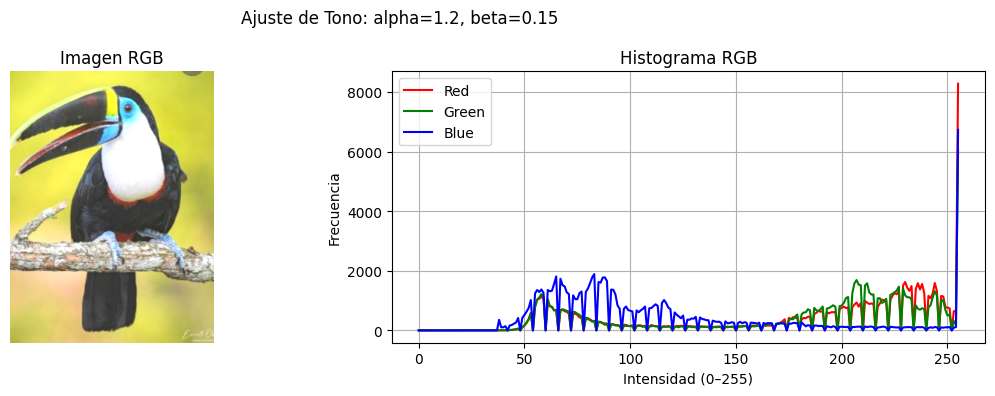

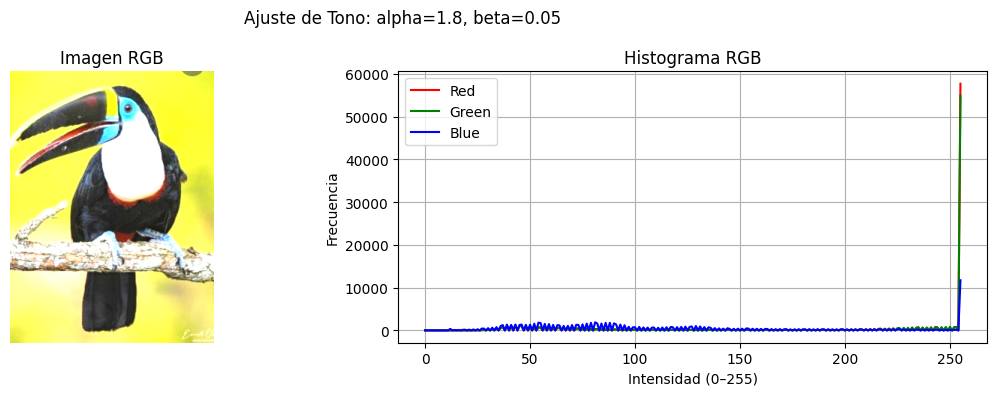

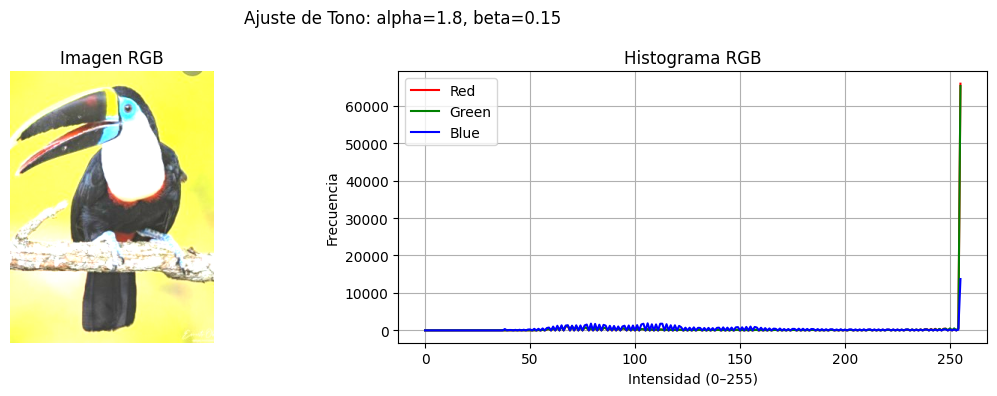

In [77]:
from PIL import Image
import torchvision.transforms as T

img_path = "images/tucan.jpg"

image = Image.open(img_path).convert("RGB")  # Asegura formato RGB
transform = T.ToTensor()
img_tensor = transform(image)

eq_tensor = equalize_image(img_tensor)
img_ahe = adaptive_hist_equalization(img_tensor, 64)


plot_image_and_histogram(img_tensor, title="Imagen Original y Histograma RGB")
plot_image_and_histogram(eq_tensor, title="Imagen Ecualizada y Histograma RGB")
plot_image_and_histogram(img_ahe, title="Imagen con Ecualización Adaptativa y Histograma RGB")

alpha = [1.2, 1.8]
beta = [0.05, 0.15]

print("***"* 20)
print("Ajuste de Tono:")
print("***"* 20)

for a in alpha:
    for b in beta:
        img_adjusted = tone_adjustment(img_tensor, alpha=a, beta=b)
        plot_image_and_histogram(img_adjusted, title=f"Ajuste de Tono: alpha={a}, beta={b}")



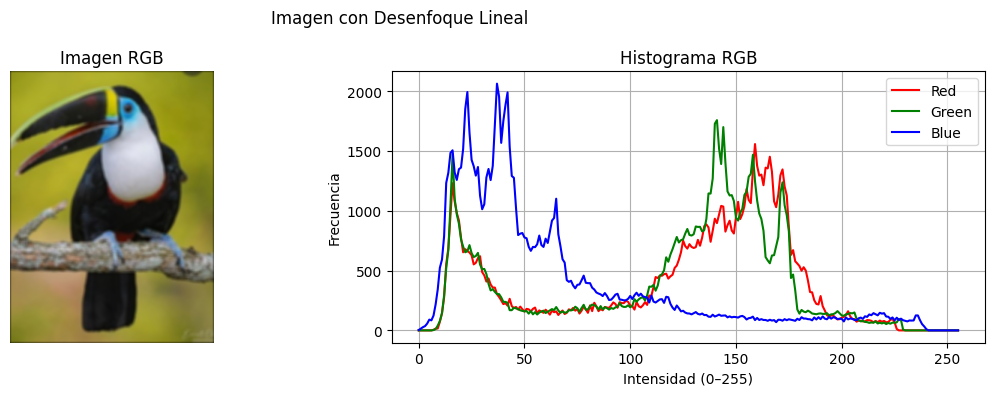

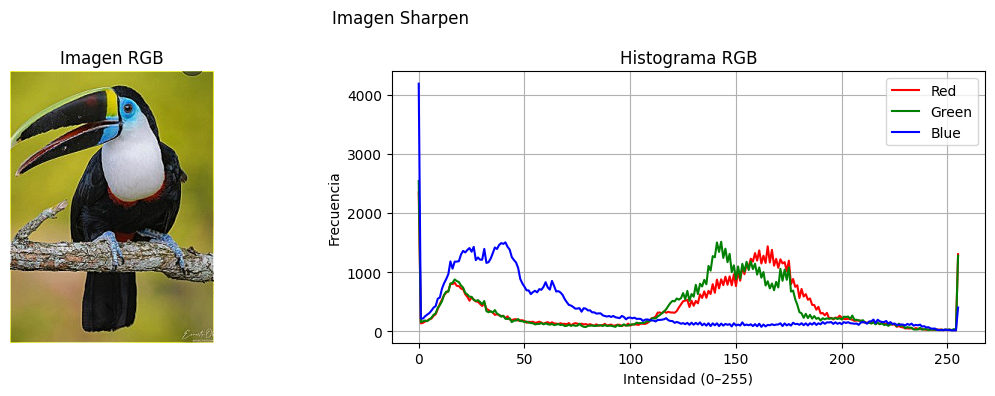

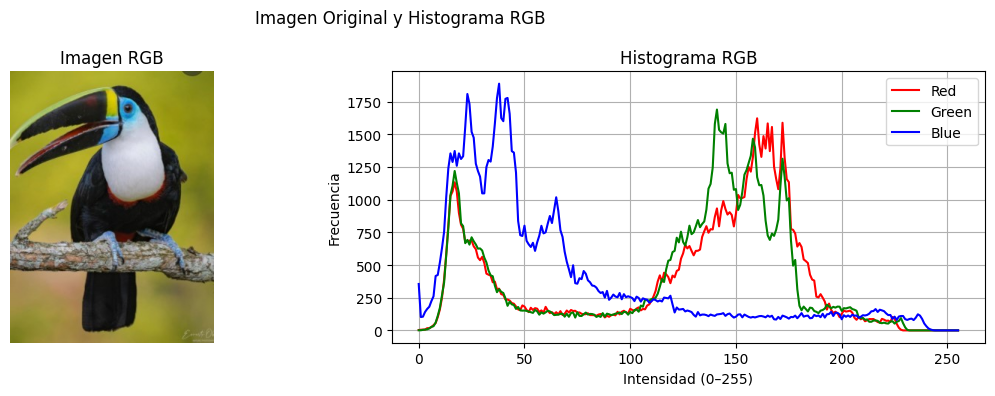

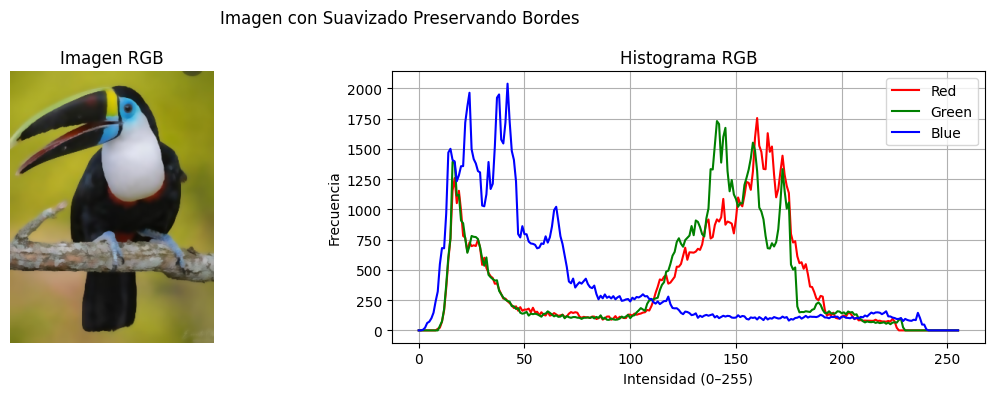

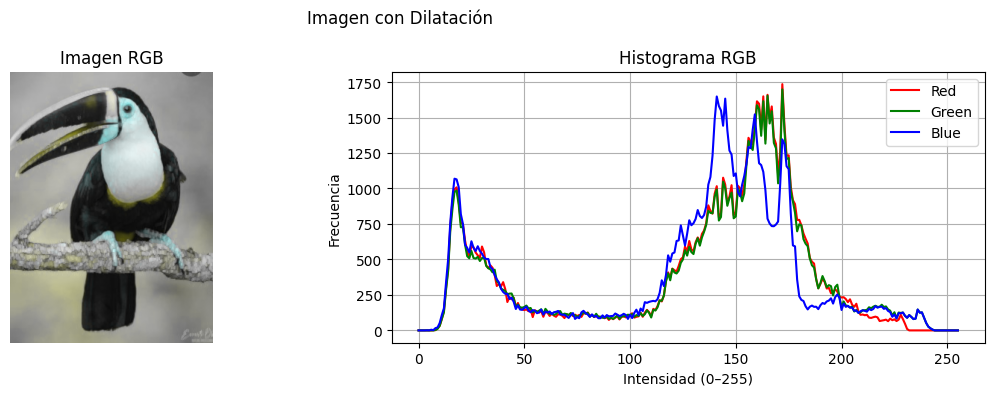

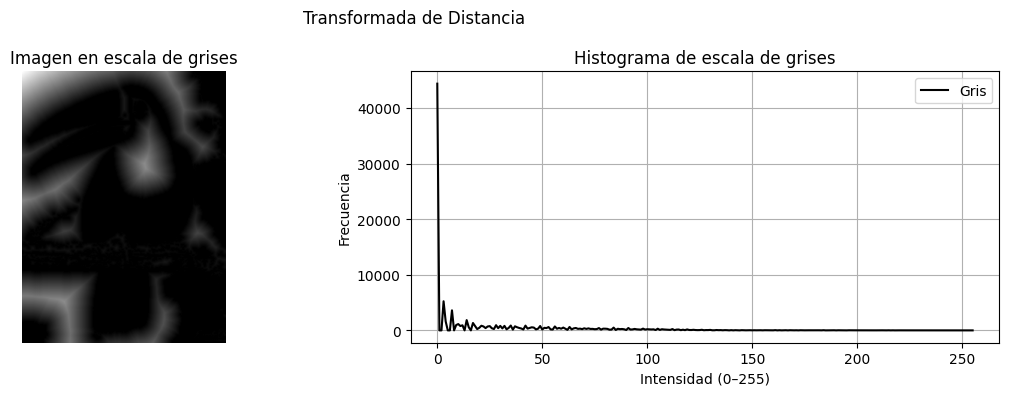

/var/folders/mt/ynd178zj0lsf9_dhk8rpqy200000gn/T/ipykernel_80732/2147625828.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap("tab20", num_labels)  # o "nipy_spectral"


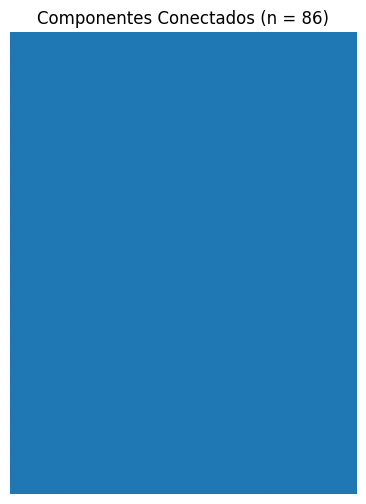

In [103]:
linear_blurred = linear_blur(img_tensor, kernel_size=5)
plot_image_and_histogram(linear_blurred, title="Imagen con Desenfoque Lineal")

sharpened = sharpen_image(img_tensor)
plot_image_and_histogram(sharpened, title="Imagen Sharpen")

plot_image_and_histogram(img_tensor, title="Imagen Original y Histograma RGB")


edge_preserved = edge_preserving_smooth(img_tensor)
plot_image_and_histogram(edge_preserved, title="Imagen con Suavizado Preservando Bordes")

dil_image = dilate_image(img_tensor)
plot_image_and_histogram(dil_image.squeeze(0), title="Imagen con Dilatación")

dist_tr= distance_transform(img_tensor)
plot_image_and_histogram(dist_tr, title="Transformada de Distancia")

binary = binarize_image(img_tensor, threshold=0.5)
labels_tensor, num_labels = connected_components(binary)
plot_connected_components(labels_tensor, num_labels)



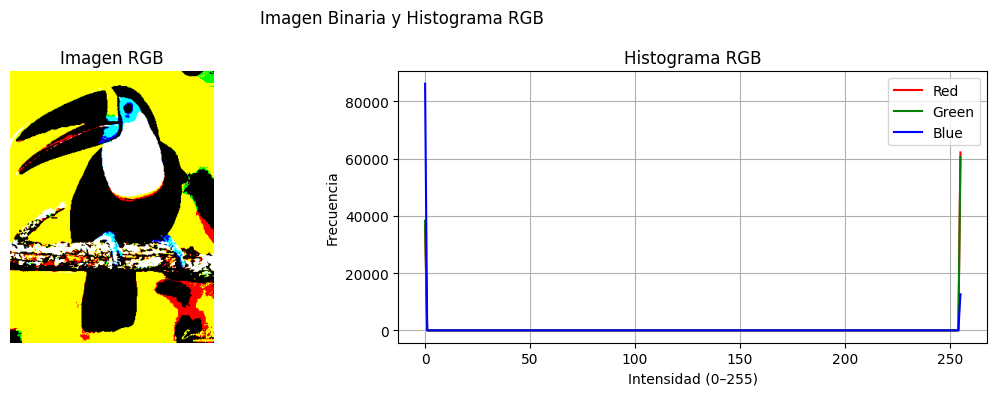

In [88]:
bin_image = binarize_image(img_tensor, threshold=0.5)
plot_image_and_histogram(bin_image, title="Imagen Binaria y Histograma RGB")

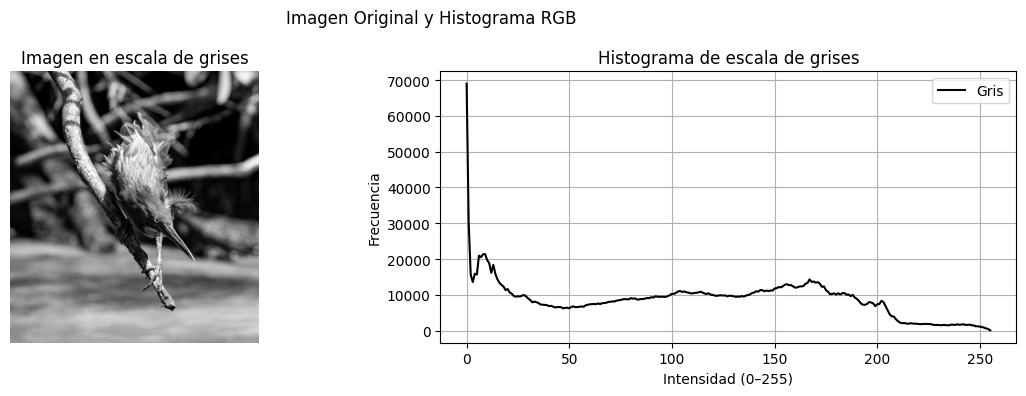

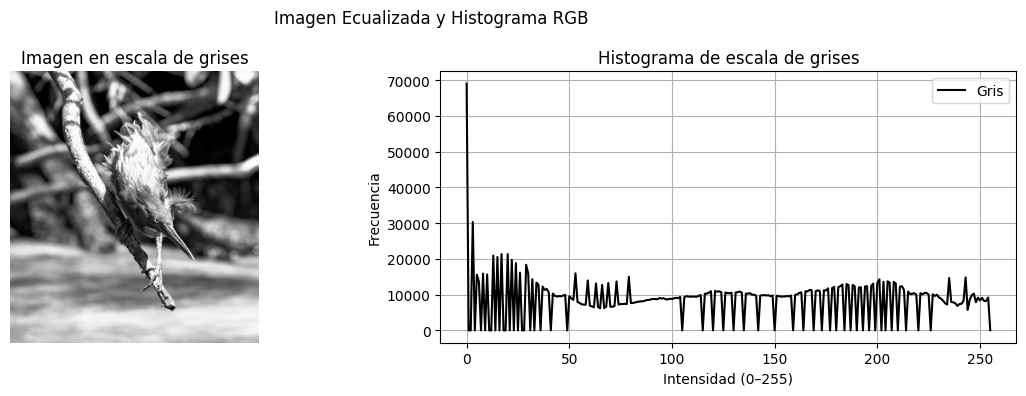

In [58]:
img_path = "images/garza.png"  
image = Image.open(img_path).convert("L")
transform = T.ToTensor()
img_tensor = transform(image)

eq_tensor = equalize_image(img_tensor)

plot_image_and_histogram(img_tensor, title="Imagen Original y Histograma RGB")
plot_image_and_histogram(eq_tensor, title="Imagen Ecualizada y Histograma RGB")
